In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
import cv2
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.layers import Add, Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D , Dropout
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils

from keras.callbacks import ModelCheckpoint
from keras.initializers import glorot_uniform 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import extract_data

In [ ]:
# Declare constants
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 64
N_CHANNELS = 3
N_CLASSES = 20
IMG_SHAPE = (IMAGE_HEIGHT,IMAGE_WIDTH,N_CHANNELS)

In [ ]:
data_dir =  #set path to the folder containing subfolders containing your images 

#list of subfolders which denote different classes of your dataset
categories = os.listdir(data_dir)

data= []
categorical_index= [] #to keep track of which class is mapped to which index

data,categorical_index = extract_data.create_data(data_dir,categories,data,categorical_index,IMAGE_HEIGHT,IMAGE_WIDTH)


In [ ]:
# randomize the data
import random

random.shuffle(data)

In [ ]:
# creating X and y from data list

X,y = extract_data.extract_features_and_labels(data)

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

print('Shape of X_train:' + str(X_train.shape))
print('Shape of y_train:' + str(y_train.shape))
print('Shape of X_test:' + str(X_test.shape))
print('Shape of y_test:' + str(y_test.shape))

In [ ]:
from keras.applications.vgg16 import VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
#rescaling our pixel values

X_train = X_train * (1./255)
X_test = X_test * (1./255)

In [ ]:
def get_model():
  inputs = Input(shape=IMG_SHAPE)
  x = inputs
  x = base_model(x, training=False)
  x = Flatten()(x)
  x = Dense(128, activation='relu',kernel_regularizer='l2')(x)
  x = Dropout(0.5)(x)
  outputs = Dense(N_CLASSES , activation='softmax')(x)

  model = Model(inputs,outputs)
  model.summary()

  return model

In [ ]:
faceModel = get_model()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 20)                2580      
Total params: 15,765,972
Trainable params: 1,051,284
Non-trainable params: 14,714,688
_______________________________________

In [ ]:

faceModel.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)
, metrics = ['accuracy'])

In [ ]:
weight_dir = "set the path where you want to store your best weights"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Train model for 100 epochs, capture the history
history = faceModel.fit(X_train,y_train, epochs=100, validation_data=(X_test,y_test),callbacks=checkpoint) #div

In [ ]:
faceModel.evaluate(X_test,y_test)

In [ ]:
import matplotlib.pyplot as plt

def plot(metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric])
  plt.title('model '+ metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


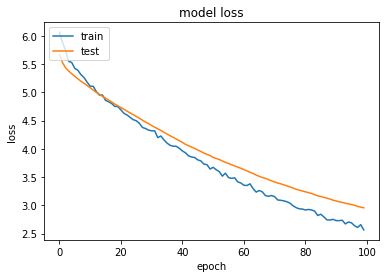

In [ ]:
plot('loss')#div

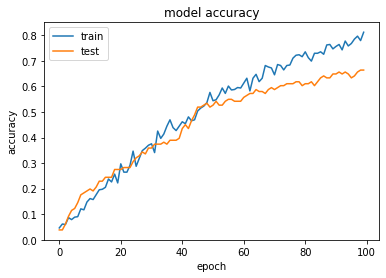

In [ ]:
plot('accuracy')#div